In [1]:
import ROOT
import numpy as np
import pandas as pd
import xgboost as xgb
from array import array
from plugins.CMS_lumi import CMS_lumi

Welcome to JupyROOT 6.24/06


/opt/conda/envs/RAPIDS/lib/python3.8/site-packages/ROOT/_facade.py:150: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return _orig_ihook(name, *args, **kwds)
/opt/conda/envs/RAPIDS/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
rdf = ROOT.RDataFrame("outTree", "../GENstudy/minitree/2017/Minitree_HDalitz_*_m125_*.root")

In [3]:
branches = rdf.GetColumnNames()
branches_remain = []
for i in branches:
    if (rdf.GetColumnType(i) == "TLorentzVector"):
        continue

    branches_remain.append(str(i))

arr = rdf.AsNumpy(columns = branches_remain)
df = pd.DataFrame(arr)
df_2gsf = df.query("category == 2")
df_2gsf

,convD0_lep1,convD0_lep2,convDz_lep1,convDz_lep2,convL0_lep1,convL0_lep2,convLz_lep1,convLz_lep2,convMatched_lep1,convMatched_lep2,...,genwei,procXS,instwei,wei,rho,rhoAll,meeRatio,meeRatioPtMax,category,higgsMass
0,-0.013087,-0.013087,0.303836,0.303836,4.947625,4.947625,16.594551,16.594551,1,1,...,-1.0,0.306342,0.077851,-0.000278,17.548597,16.670883,0.973041,0.973041,2,125.427134
3,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0,0,...,1.0,0.306342,0.077851,0.000192,20.832499,19.439362,211.155002,211.155002,2,128.205762
4,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0,0,...,1.0,0.306342,0.077851,0.000168,23.434023,23.106314,1.155058,1.155058,2,124.902890
6,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0,0,...,1.0,0.306342,0.077851,0.000168,24.368187,22.780258,1.461990,1.461990,2,127.837470
10,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0,0,...,1.0,0.306342,0.077851,0.000182,12.582890,11.956555,17.617883,17.617883,2,126.749978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504795,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0,0,...,1.0,3.934980,1.000000,0.001191,28.327314,27.006289,10.324729,42.340461,2,125.523991
504797,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0,0,...,1.0,3.934980,1.000000,0.001222,11.571012,11.451828,1.061538,1.061538,2,125.527517
504802,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0,0,...,1.0,3.934980,1.000000,0.001850,15.002759,15.067405,1.153903,1.153903,2,124.033929
504804,-0.007417,-0.007417,-3.805010,-3.805010,-0.177747,-0.177747,3.673210,3.673210,1,1,...,1.0,3.934980,1.000000,0.001713,20.287136,19.262856,5.269624,5.269624,2,126.390131


In [4]:
import pickle

models = {
    "M2EB": pickle.load(open("../ID_Trainer/Results/Output_Merged2GsfID_EB_2017_daskNoGJetsV2/XGB/XGB_modelXGB.pkl", "rb")),
    "M2EE": pickle.load(open("../ID_Trainer/Results/Output_Merged2GsfID_EE_2017_daskNoGJetsV2/XGB/XGB_modelXGB.pkl", "rb"))
}

features = [    
    "rho",
    "eleSCEta_lep1",
    "eleSCRawEn_lep1",

    "eleD0_lep1",
    "eleDz_lep1",
    "eleSIP_lep1",
    # "elePtError_lep1",
    "eleSCEtaWidth_lep1",
    "eleSCPhiWidth_lep1",
    "eleHoverE_lep1",
    # "eleEoverP_lep1",
    # "eleEoverPout_lep1",
    # "eleEoverPInv_lep1",
    "eleBrem_lep1",
    # "eledEtaAtVtx_lep1",
    # "eledPhiAtVtx_lep1",
    "eleSigmaIEtaIEtaFull5x5_lep1",
    "eleSigmaIPhiIPhiFull5x5_lep1",
    # "elePFChIso_lep1",
    # "elePFPhoIso_lep1",
    # "elePFNeuIso_lep1",
    # "elePFPUIso_lep1",
    "eleR9Full5x5_lep1",

    # "eleGSFChi2_lep1",
    # "gsfPtRatio_lep1",
    # "gsfDeltaR_lep1",
    # "gsfRelPtRatio_lep1",
    # "gsfPtSum_lep1"
]

In [5]:
def convert_class(arr, Type):
    if Type not in ["Merged-1Gsf", "Merged-2Gsf"]:
        print("This type of model is not available!(Merged-1Gsf or Merged-2Gsf)")
        sys.exit(1)

    new_arr = [i+1 for i in arr] if Type == "Merged-1Gsf" else [0 if i == 0 else i+1 for i in arr]

    return np.asarray(new_arr)


# EB 2gsf prediction 
df_flat_EB_2gsf = df_2gsf.query("(abs(eleSCEta_lep1) < 1.479)")
x_EB_2gsf = xgb.DMatrix(df_flat_EB_2gsf.loc[:,features].values)
df_flat_EB_2gsf.insert(loc = 0, column = "eleClass_lep1", value = convert_class(models["M2EB"].predict(x_EB_2gsf).argmax(axis = 1), "Merged-2Gsf"))

# EE 2gsf prediction 
df_flat_EE_2gsf = df_2gsf.query("(abs(eleSCEta_lep1) >= 1.479)")
x_EE_2gsf = xgb.DMatrix(df_flat_EE_2gsf.loc[:,features].values)
df_flat_EE_2gsf.insert(loc = 0, column = "eleClass_lep1", value = convert_class(models["M2EE"].predict(x_EE_2gsf).argmax(axis = 1), "Merged-2Gsf"))

df_new_EBEE = pd.concat([df_flat_EB_2gsf, df_flat_EE_2gsf], sort = False).sort_index()
df_new_EBEE

,eleClass_lep1,convD0_lep1,convD0_lep2,convDz_lep1,convDz_lep2,convL0_lep1,convL0_lep2,convLz_lep1,convLz_lep2,convMatched_lep1,...,genwei,procXS,instwei,wei,rho,rhoAll,meeRatio,meeRatioPtMax,category,higgsMass
0,0,-0.013087,-0.013087,0.303836,0.303836,4.947625,4.947625,16.594551,16.594551,1,...,-1.0,0.306342,0.077851,-0.000278,17.548597,16.670883,0.973041,0.973041,2,125.427134
3,2,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0,...,1.0,0.306342,0.077851,0.000192,20.832499,19.439362,211.155002,211.155002,2,128.205762
4,0,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0,...,1.0,0.306342,0.077851,0.000168,23.434023,23.106314,1.155058,1.155058,2,124.902890
6,2,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0,...,1.0,0.306342,0.077851,0.000168,24.368187,22.780258,1.461990,1.461990,2,127.837470
10,0,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0,...,1.0,0.306342,0.077851,0.000182,12.582890,11.956555,17.617883,17.617883,2,126.749978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504795,0,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0,...,1.0,3.934980,1.000000,0.001191,28.327314,27.006289,10.324729,42.340461,2,125.523991
504797,0,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0,...,1.0,3.934980,1.000000,0.001222,11.571012,11.451828,1.061538,1.061538,2,125.527517
504802,0,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0,...,1.0,3.934980,1.000000,0.001850,15.002759,15.067405,1.153903,1.153903,2,124.033929
504804,0,-0.007417,-0.007417,-3.805010,-3.805010,-0.177747,-0.177747,3.673210,3.673210,1,...,1.0,3.934980,1.000000,0.001713,20.287136,19.262856,5.269624,5.269624,2,126.390131


In [6]:
data = {key: df_new_EBEE[key].values for key in df_new_EBEE.columns}
rdf_new = ROOT.RDF.MakeNumpyDataFrame(data)

rdf_new.Display({"eleClass_lep1", "category"}).Print()

eleClass_lep1 | category | 
0             | 2        | 
2             | 2        | 
0             | 2        | 
2             | 2        | 
0             | 2        | 


In [7]:
rdf_new = rdf_new.Define("weight", "mcwei * puwei")

In [8]:
# selection
sel_den = "&&".join([
    "elePresel_lep1 == 1",
    "abs(eleSCEta_lep1) < 1.4442",
])
sel_num = sel_den + "&& eleClass_lep1 == 0"

h_num_Sig = rdf_new.Filter(sel_num).Histo1D(("h1", " ", 4, array("d", [15., 25., 35., 65, 150.])), "eleCalibPt_lep1", "weight").GetPtr()
h_den_Sig = rdf_new.Filter(sel_den).Histo1D(("h1", " ", 4, array("d", [15., 25., 35., 65, 150.])), "eleCalibPt_lep1", "weight").GetPtr()
eff_Sig = ROOT.TEfficiency(h_num_Sig, h_den_Sig)
eff_Sig.SetStatisticOption(ROOT.TEfficiency.kBUniform)
eff_Sig.SetConfidenceLevel(0.683)
eff_Sig.SetPosteriorMode(1)

Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency


In [19]:
rdf_MC = ROOT.RDataFrame("outTree", "./miniTree/2017/miniTree_ZGToLLG_2017.root").Define("weight", "mcwei * puwei")
rdf_Da = ROOT.RDataFrame("outTree",  "./miniTree/2017/miniTree_Data_2017.root")

rconv = 4
sel_den = "&&".join([
    "convVtxRadius_lep1 < {}".format(rconv), 
    "isHggPho_lep1 == 1",
    "isEBPho_lep1 == 1"
])
sel_num = sel_den + "&& eleClass_lep1 == 0"

In [20]:
h_num_MC = rdf_MC.Filter(sel_num).Histo1D(("h1", " ", 4, array("d", [15., 25., 35., 65, 150.])), "phoCalibEt_lep1", "weight").GetPtr()
h_den_MC = rdf_MC.Filter(sel_den).Histo1D(("h1", " ", 4, array("d", [15., 25., 35., 65, 150.])), "phoCalibEt_lep1", "weight").GetPtr()
eff_MC = ROOT.TEfficiency(h_num_MC, h_den_MC)
eff_MC.SetStatisticOption(ROOT.TEfficiency.kBUniform)
eff_MC.SetConfidenceLevel(0.683)
eff_MC.SetPosteriorMode(1)

# Data efficiency calculation
h_num_Da = rdf_Da.Filter(sel_num).Histo1D(("h1", " ", 4, array("d", [15., 25., 35., 65, 150.])), "phoCalibEt_lep1").GetPtr()
h_den_Da = rdf_Da.Filter(sel_den).Histo1D(("h1", " ", 4, array("d", [15., 25., 35., 65, 150.])), "phoCalibEt_lep1").GetPtr()
eff_Da = ROOT.TEfficiency(h_num_Da, h_den_Da)
eff_Da.SetStatisticOption(ROOT.TEfficiency.kBUniform)
eff_Da.SetConfidenceLevel(0.683)
eff_Da.SetPosteriorMode(1)

Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


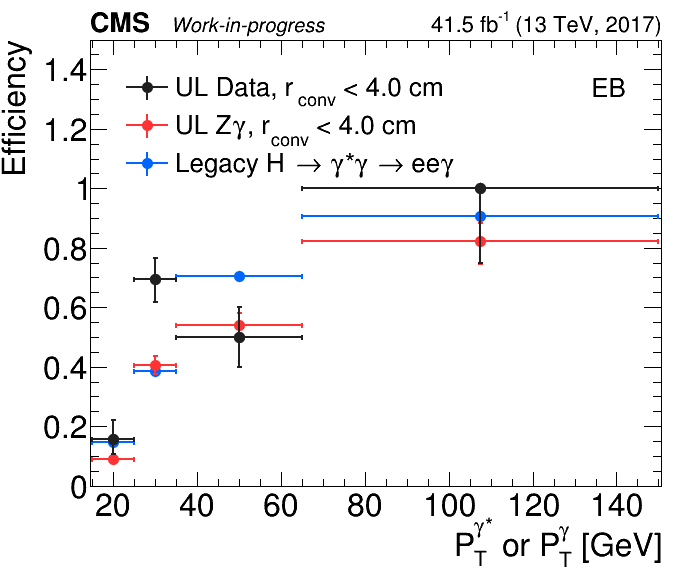

In [21]:
ROOT.gStyle.SetPadTickX(1)
ROOT.gStyle.SetPadTickY(1)
ROOT.gStyle.SetOptStat(0)

c1 = ROOT.TCanvas("c1", "", 700, 600)
c1.SetBottomMargin(0.05)
c1.SetTopMargin(0.07)
c1.SetRightMargin(0.05)
c1.SetLeftMargin(0.13)
c1.SetBottomMargin(0.15)
c1.cd()

eff_Sig.SetTitle(";P^{#gamma*}_{T} or P^{#gamma}_{T} [GeV];Efficiency") #("global title; x-axis title; y-axis title")
eff_Sig.SetMarkerColor(ROOT.kAzure-3)
eff_Sig.SetMarkerSize(1.4)
eff_Sig.SetMarkerStyle(20)
eff_Sig.SetLineColor(ROOT.kAzure-3)
eff_Sig.SetLineWidth(2)
eff_Sig.Draw("AP")  

eff_Da.SetMarkerColor(ROOT.TColor.GetColor("#202020"))
eff_Da.SetMarkerSize(1.4)
eff_Da.SetMarkerStyle(20)
eff_Da.SetLineColor(ROOT.TColor.GetColor("#202020"))
eff_Da.SetLineWidth(2)
eff_Da.Draw("P SAME")

eff_MC.SetMarkerColor(ROOT.kRed-4)
eff_MC.SetMarkerSize(1.4)
eff_MC.SetMarkerStyle(20)
eff_MC.SetLineColor(ROOT.kRed-4)
eff_MC.SetLineWidth(2)
eff_MC.Draw("P SAME")  
eff_Da.Draw("P SAME")

c1.Update()
efferr = eff_Sig.GetPaintedGraph()
efferr.GetYaxis().SetRangeUser(0, 1.5)
efferr.GetYaxis().SetTickSize(0.03)
efferr.GetYaxis().SetTitleSize(0.06)
efferr.GetYaxis().SetLabelSize(0.06)
efferr.GetYaxis().SetTitleOffset(1.1)

efferr.GetXaxis().SetRangeUser(15 ,150)
efferr.GetXaxis().SetTickSize(0.03)
efferr.GetXaxis().SetTitleSize(0.06)
efferr.GetXaxis().SetLabelSize(0.06)
# efferr.GetXaxis().SetLabelOffset(0.1)
efferr.GetXaxis().SetTitleOffset(1)


leg = ROOT.TLegend(0.17, 0.68, 0.5, 0.88)
leg.SetTextSize(0.05)
leg.AddEntry(eff_Da, "UL Data, r_{conv} < %.1f cm" %rconv, "lep")
leg.AddEntry(eff_MC, "UL Z#gamma, r_{conv} < %.1f cm" %rconv, "lep")
leg.AddEntry(eff_Sig, "Legacy H #rightarrow #gamma*#gamma #rightarrow ee#gamma", "lep")
leg.SetFillColor(0)
leg.SetLineColor(0)
leg.Draw()

ltx = ROOT.TLatex()
ltx.SetNDC()
ltx.SetTextFont(42)
ltx.SetTextSize(0.05)
ltx.DrawLatex(0.85, 0.83, "EB")

CMS_lumi(c1, 4, 0, "41.5 fb^{-1}", 2017, True, "Work-in-progress", "", "")

c1.Draw()

In [12]:
# import os

# outRes = "./plots"
# if not os.path.exists(outRes):
#     os.makedirs(outRes)
    
# c1.Print("{}/effCompZgHDalitzWith{}cm.pdf".format(outRes, rconv))